In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

In [5]:
class GpsLocation():
    def __init__(self, lat, lon, altitude):
        self._lat = lat
        self._lon = lon
        self._altitude = 0

    @property
    def lat(self):
        return self._lat

    @property
    def lon(self):
        return self._lon

    @property
    def altitude(self):
        return self._altitude

    def __repr__(self):
        return "Lat: {} Lon: {} Altitude {}".format(self.lat, self.lon, self.altitude)


# Plan path from start to goal

load_map: Data North Min: -316, Max: 605
load_map: Data East Min: -445, Max: 476
[Planner] Home Gps Location: Lat: 37.79248 Lon: -122.39745 Altitude 0
Start:  (0, 0, 0)
Goal:  [268  49   0]
Grid[Goal] 0.0


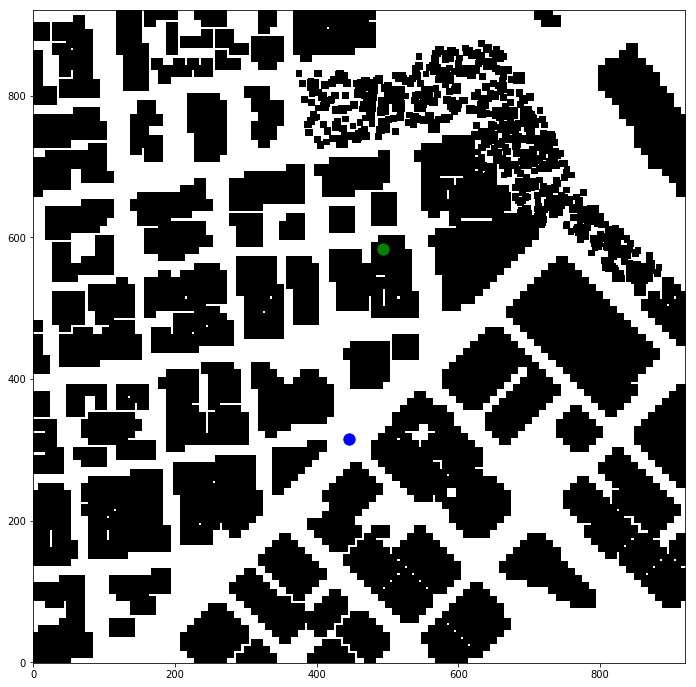

In [6]:
from planner import Planner, GpsLocation
from udacidrone.frame_utils import global_to_local, local_to_global

p = Planner()
p.load_map()
grid = p.create_grid()
grid25 = p.grid25
n_min = p.worldmap.north_min
e_min = p.worldmap.east_min

lon0 = -122.397450
lat0 = 37.792480
global_home = (lon0, lat0, 0)

start = (0,0,0)
#goal_gps = GpsLocation(37.794719, -122.396987, 0)
goal_gps = GpsLocation(37.79489867, -122.39687191, 0)
goal = global_to_local(goal_gps, global_home)
goal = np.array([int(goal[0]), int(goal[1]), 0])

# goal = (248.67913418 + 20, 49.16487749,0.)
# print(local_to_global(goal, global_home))
# print(local_to_global((goal[0], goal[1] + 6, 0), global_home))

print('Start: ', start)
print('Goal: ', goal)
print('Grid[Goal]', grid[goal[0], goal[1]])

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')
plt.scatter(start[1] - e_min, start[0] - n_min, marker='o', s = 128, color='blue')
plt.scatter(goal[1] - e_min, goal[0] - n_min, marker='o', s = 128, color='green')

plt.show()

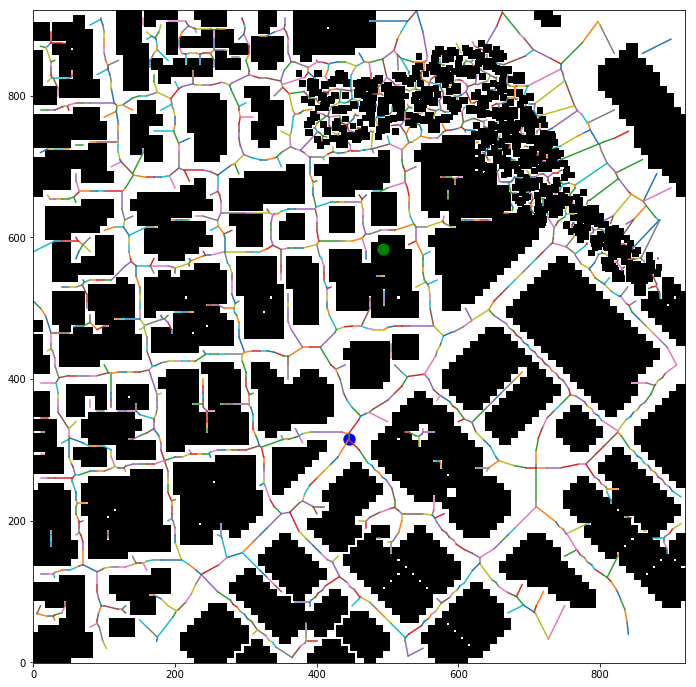

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

edges = p.get_voronoi_edges()

fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')

for y1, x1, y2, x2 in edges:
     plt.plot([x1, x2], [y1, y2])

plt.scatter(start[1] - e_min, start[1] - n_min, color='blue', s = 128)
plt.scatter(goal[1] - e_min, goal[0] - n_min, color='green', s = 128)

plt.show()

# Start to Goal with Voronoi

# create_voronoi_graph

## Graph Nodes

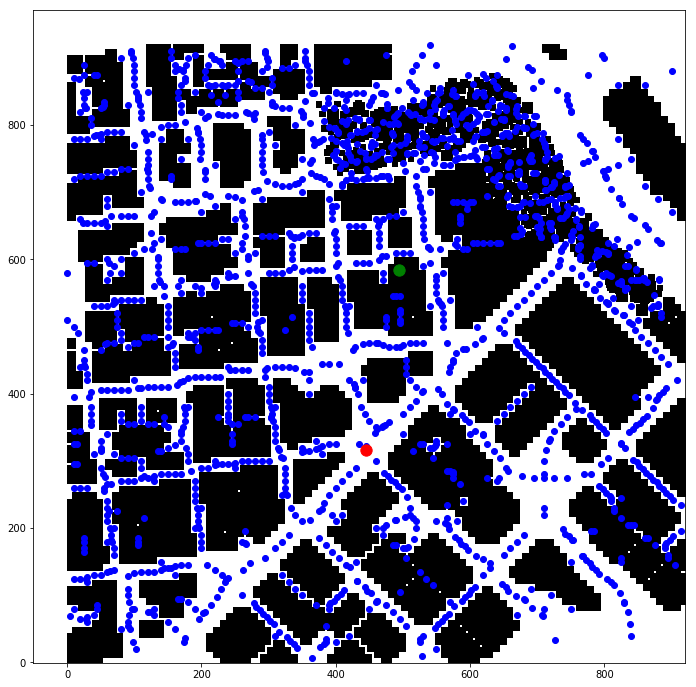

In [9]:
import os

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

graph, t = p.create_voronoi_graph()

#print(dir(graph))
fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')

f = open('check.txt', "w")

graph_list = list(graph)
for n in graph_list:
    plt.scatter(n[1] - e_min, n[0] - n_min, color='blue')
    f.write(str(n))
#     print(n)

f.close()

plt.scatter(start[1] - e_min, start[1] - n_min, color='red', s = 128)
plt.scatter(goal[1] - e_min, goal[0] - n_min, color='green', s = 128)

plt.show()

## Check Closest To Goal (using tree)

[[348]]


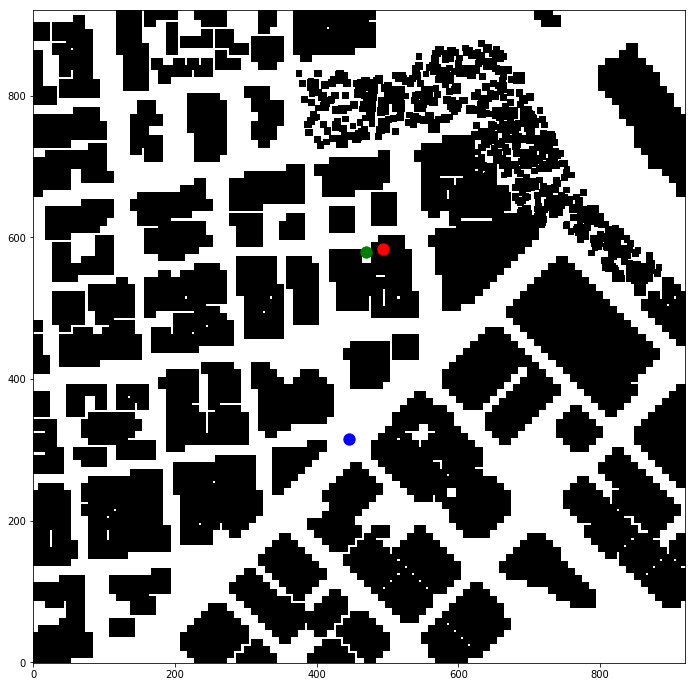

In [11]:
graph_list = list(graph)
# cg_index = t.query([[goal[0], goal[1], 0]], k = 1, return_distance = False)
cg_index = t.query([[goal[0], goal[1], 0]], k = 1, return_distance = False)
print(cg_index)

# print('Node closes to goal: ', cg)

fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')

for n in cg_index[0]:
    cg = graph_list[n]
    plt.scatter(cg[1] - e_min, cg[0] - n_min, color='green', s = 128)


plt.scatter(start[1] - e_min, start[0] - n_min, color='blue', s = 128)
plt.scatter(goal[1] - e_min, goal[0] - n_min, color='red', s = 128)

plt.show()

# Path from Start to Closest Goal

In [16]:
def distance_heuristic(n1, n2):
    return np.linalg.norm((n1, n2))

start3d = start
goal3d = goal

# Create voronoi graph to create a 2d path
graph, graph_nodes_kd = p.create_voronoi_graph()  # graph and its KD

# find the closest location on the graph that matches the start and the goal states
indices = graph_nodes_kd.query([start3d, goal3d], 
                        k = 1, 
                        return_distance = False)

graph_list = list(graph)

c_start = graph_list[indices[0][0]]
c_goal = graph_list[indices[1][0]]

path = p.a_star_graph(graph, distance_heuristic, c_start, c_goal)

print('Pruning path...')
pruned_path = p.prune_path(path)

print('Path pruned. Length: ', len(pruned_path))

Found a path.
Pruning path...
Path pruned. Length:  28


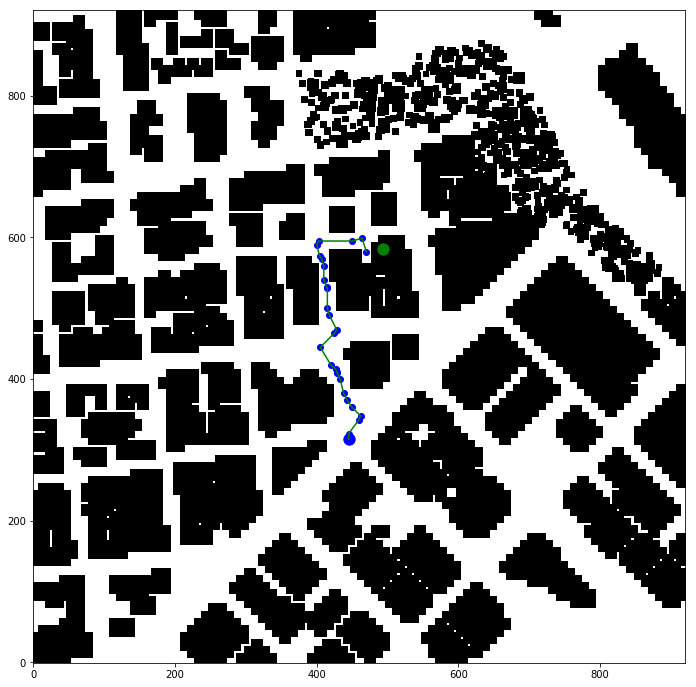

In [17]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.scatter(start[1] - e_min, start[0] - n_min, marker='o', s = 128, color='blue')
plt.scatter(goal[1] - e_min, goal[0] - n_min, marker='o', s = 128, color='green')

x = []
y = []
for point in pruned_path:
    plt.scatter(point[1] - e_min, point[0] - n_min, color='blue')
    x.append(point[1] - e_min)
    y.append(point[0] - n_min)

plt.plot(x, y, color='green')
plt.show()

Start:  (0, 0, 0)
Goal:  [268  49   0]
Closest To Start (0, 0, 0) is (-1, 0, -5)
Closest To Goal [268  49   0] is (264, 25, -5) 
Running a_star
Found a path.
Pruning path...
Path pruned. Length:  28
Since closest goal is not on the graph, using action based planner for last node...
Original goal: [268  49   0], closest: (264, 25, -5)
Goal state is an obstacle. Will land on top of it
Start: (268, 49, -10), Goal: (264, 25, -5)
Current equals goal, going out
Action Path:  [(264, 25, -5, 0), (264, 25, -6, 35.0), (264, 25, -7, 69.0), (264, 25, -8, 102.0), (264, 25, -9, 134.0), (264, 25, -10, 165.0), (264, 25, -11, 195.0), (264, 26, -11, 224.0), (264, 27, -11, 252.0), (264, 28, -11, 279.0), (264, 29, -11, 305.0), (264, 30, -11, 330.0), (264, 31, -11, 354.0), (264, 32, -11, 377.0), (264, 33, -11, 399.0), (264, 34, -11, 420.0), (264, 35, -11, 440.0), (264, 36, -11, 459.0), (264, 37, -11, 477.0), (264, 38, -11, 494.0), (264, 39, -11, 510.0), (264, 40, -11, 525.0), (264, 41, -11, 539.0), (264, 4

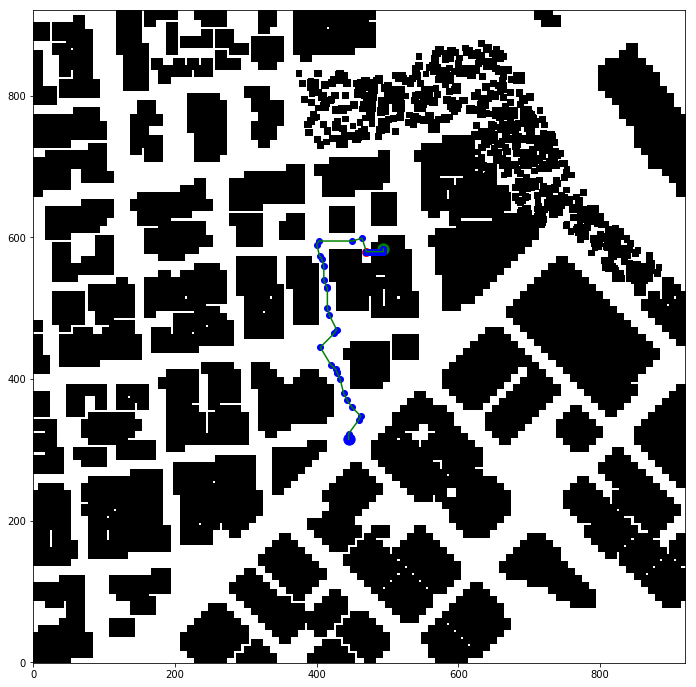

In [18]:
print('Start: ', start)
print('Goal: ', goal)

path2d_cost = p.plan_route(start, goal)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')
plt.scatter(start[1] - e_min, start[0] - n_min, marker='o', s = 128, color='blue')
plt.scatter(goal[1] - e_min, goal[0] - n_min, marker='o', s = 128, color='green')

plt.scatter(p.c_goal[1] - e_min, p.c_goal[0] - n_min, marker='o', s = 64, color='red')

x = []
y = []
for point in path2d_cost:
    plt.scatter(point[1] - e_min, point[0] - n_min, color='blue')
    x.append(point[1] - e_min)
    y.append(point[0] - n_min)

plt.plot(x, y, color='green')
plt.show()